In [31]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import torch.nn.functional as F

import math


In [32]:

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


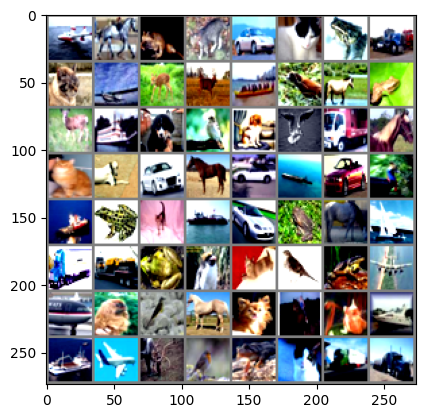

airplane horse frog cat automobile cat frog truck cat airplane deer deer ship bird horse frog deer ship dog bird dog bird truck horse cat dog automobile horse automobile ship automobile bird ship frog cat ship automobile frog horse ship truck truck frog bird cat bird frog airplane airplane dog bird horse dog horse cat ship ship airplane deer bird frog cat truck truck


In [33]:


import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(64)))


In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [43]:
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Linear projection of flattened patches
        self.projection = nn.Conv2d(
            self.num_channels, 
            self.hidden_size, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Projection layers for query, key, and value
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  # Batch, Sequence length, Embedding dimension

        # Project to query, key, value
        qkv = self.qkv_proj(x)  # (B, N, 3 * D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (B, num_heads, N, head_dim)

        # Scaled dot-product attention
        # (B, num_heads, N, head_dim) @ (B, num_heads, head_dim, N) -> (B, num_heads, N, N)
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Apply attention weights to values
        # (B, num_heads, N, N) @ (B, num_heads, N, head_dim) -> (B, num_heads, N, head_dim)
        context = torch.matmul(attn_probs, v)
        
        # Reshape back to original dimensions
        # (B, num_heads, N, head_dim) -> (B, N, D)
        context = context.transpose(1, 2).reshape(B, N, D)
        
        # Final projection
        out = self.out_proj(context)
        return out


class ViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        # Layer Norm 1 (for attention)
        self.norm1 = nn.LayerNorm(input_dim)
        # Multi-head self-attention
        self.attn = MultiHeadSelfAttention(input_dim, num_heads, dropout)
        # Layer Norm 2 (for MLP)
        self.norm2 = nn.LayerNorm(input_dim)
        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pre-LayerNorm architecture as in the original paper
        # First attention block with residual connection
        x = x + self.attn(self.norm1(x))
        # Then MLP block with residual connection
        x = x + self.mlp(self.norm2(x))
        return x


class ViTClassifier(nn.Module):
    def __init__(
        self, image_size, patch_size, num_channels, embed_dim, hidden_dim, num_heads,
        num_layers, num_classes, dropout=0.0
    ):
        super().__init__()
        
        # Create config for patch embedding
        patch_config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": embed_dim
        }
        
        # Patch embedding layer
        self.patch_embedding = PatchEmbeddings(patch_config)
        self.num_patches = self.patch_embedding.num_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        # Initialize with truncated normal distribution
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.transformer = nn.Sequential(
            *[ViTEncoder(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
        # Layer normalization for the final output
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Get batch size
        B = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embedding(x)  # (B, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embed  # (B, 1 + num_patches, embed_dim)
        x = self.dropout(x)
        
        # Apply transformer blocks
        x = self.transformer(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Use the class token for classification
        x = x[:, 0]  # (B, embed_dim)
        
        # Classification head
        x = self.head(x)  # (B, num_classes)
        
        return x

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models.vision_transformer import vit_b_16
import math
import os

In [ ]:


def get_attention_maps(model, img_tensor, layer_idx=-1, head_idx=None):

    attention_maps = []
    
    def hook_fn(module, input, output):
        # attention weights shape: (batch, num_heads, seq_len, seq_len)
        attention_maps.append(output[1])  # Assuming output[1] contains attention weights
    
    if hasattr(model, 'blocks'):
        # Register hook for DINO ViT
        attn_module = model.blocks[layer_idx].attn
    else:
        # Register hook for custom ViT
        attn_module = model.transformer[layer_idx].attn
        
    hook = attn_module.register_forward_hook(hook_fn)
    
    # Forward pass
    with torch.no_grad():
        _ = model(img_tensor)
    
    # Remove hook
    hook.remove()
    
    # Get attention weights: (batch, num_heads, seq_len, seq_len)
    attn_weights = attention_maps[0]
    
    # Extract attention from cls token (index 0) to patch tokens
    cls_attn = attn_weights[0, :, 0, 1:]  # Shape: (num_heads, num_patches)
    
    # If head_idx is provided, select that head, otherwise average across heads
    if head_idx is not None:
        cls_attn = cls_attn[head_idx].unsqueeze(0)
    
    # Average across heads if head_idx is None
    cls_attn_mean = cls_attn.mean(dim=0)  # Shape: (num_patches)
    
    return cls_attn_mean

def visualize_attention(img_path, model, img_size=224, patch_size=16):

    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    
    # Get attention maps
    attn_map = get_attention_maps(model, img_tensor)
    
    # Reshape attention map to 2D grid
    num_patches = int(np.sqrt(attn_map.shape[0]))
    attn_map_2d = attn_map.reshape(num_patches, num_patches).cpu().numpy()
    
    # Resize attention map to match original image size
    attn_map_resized = Image.fromarray(
        (attn_map_2d * 255 / attn_map_2d.max()).astype(np.uint8)
    ).resize((img_size, img_size), Image.BICUBIC)
    attn_map_resized = np.array(attn_map_resized) / 255.0
    
    # Plot original image and attention map
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image
    img_display = transforms.Resize((img_size, img_size))(img)
    ax[0].imshow(img_display)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    # Attention map
    ax[1].imshow(attn_map_resized, cmap='viridis')
    ax[1].set_title("Attention Map (CLS Token)")
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"attn_map_{os.path.basename(img_path)}")
    plt.show()
    
def visualize_dino_attention():

    model = vit_b_16(pretrained=True)
    model.eval()
    
    img_paths = [
        "image1.jpg",
        "image2.jpg"
    ]
    
    for img_path in img_paths:
        visualize_attention(img_path, model)


# 2. ViT CIFAR-10 Attention Maps

def visualize_vit_cifar10_attention(model, test_loader):
    """
    Visualize attention maps from a ViT model trained on CIFAR-10.
    
    Args:
        model: Trained ViT model
        test_loader: DataLoader for CIFAR-10 test set
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(test_loader))
    
    # Select a few images to visualize
    num_images = 5
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Get the last attention layer
    last_layer_idx = len(model.transformer) - 1
    num_heads = model.transformer[last_layer_idx].attn.num_heads
    
    with torch.no_grad():
        # Forward pass to get the class token
        _ = model(images)
        
        # Visualize attention maps for each image
        for img_idx in range(num_images):
            img = images[img_idx:img_idx+1]
            
            # Create a figure for this image
            fig, axes = plt.subplots(2, (num_heads + 1) // 2, figsize=(15, 6))
            axes = axes.flatten()
            
            # Original image
            plt.figure(figsize=(4, 4))
            plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
            plt.title(f"Original Image (Label: {labels[img_idx].item()})")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f"cifar10_original_img_{img_idx}.png")
            plt.close()
            
            # Get attention maps for each head
            all_head_maps = []
            for head_idx in range(num_heads):
                # Get attention map for this head
                attn_map = get_attention_maps(model, img, layer_idx=last_layer_idx, head_idx=head_idx)
                all_head_maps.append(attn_map)
                
                # Reshape to 2D grid
                num_patches = int(np.sqrt(attn_map.shape[0]))
                attn_map_2d = attn_map.reshape(num_patches, num_patches).cpu().numpy()
                
                # Plot attention map for this head
                plt.figure(figsize=(4, 4))
                plt.imshow(attn_map_2d, cmap='viridis')
                plt.title(f"Head {head_idx}")
                plt.colorbar()
                plt.tight_layout()
                plt.savefig(f"cifar10_head_{head_idx}_img_{img_idx}.png")
                plt.close()
            
            # Aggregate attention map (average across heads)
            avg_attn_map = torch.stack(all_head_maps).mean(dim=0)
            num_patches = int(np.sqrt(avg_attn_map.shape[0]))
            avg_attn_map_2d = avg_attn_map.reshape(num_patches, num_patches).cpu().numpy()
            
            # Plot average attention map
            plt.figure(figsize=(4, 4))
            plt.imshow(avg_attn_map_2d, cmap='viridis')
            plt.title("Average Across Heads")
            plt.colorbar()
            plt.tight_layout()
            plt.savefig(f"cifar10_avg_attn_img_{img_idx}.png")
            plt.close()
            
            # Visualize attention across layers
            fig, axes = plt.subplots(1, len(model.transformer), figsize=(15, 3))
            for layer_idx in range(len(model.transformer)):
                attn_map = get_attention_maps(model, img, layer_idx=layer_idx)
                num_patches = int(np.sqrt(attn_map.shape[0]))
                attn_map_2d = attn_map.reshape(num_patches, num_patches).cpu().numpy()
                
                axes[layer_idx].imshow(attn_map_2d, cmap='viridis')
                axes[layer_idx].set_title(f"Layer {layer_idx}")
                axes[layer_idx].axis('off')
            
            plt.tight_layout()
            plt.savefig(f"cifar10_all_layers_img_{img_idx}.png")
            plt.close()


# 3. Attention Rollout

def compute_attention_rollout(model, img_tensor):
    """
    Compute attention rollout as described in the ViT paper and 
    "Quantifying Attention Flow in Transformers" paper.
    
    Args:
        model: ViT model
        img_tensor: Input image tensor (batched)
        
    Returns:
        Attention rollout map
    """
    # Extract attention weights from all layers
    attention_maps = []
    
    def attention_hook(module, input, output):
        # Extract attention weights
        attention_maps.append(output[1])  # Assuming output[1] contains attention weights
    
    # Register hooks for all attention layers
    hooks = []
    for layer_idx in range(len(model.transformer)):
        if hasattr(model, 'blocks'):
            # For DINO ViT
            hook = model.blocks[layer_idx].attn.register_forward_hook(attention_hook)
        else:
            # For custom ViT
            hook = model.transformer[layer_idx].attn.register_forward_hook(attention_hook)
        hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(img_tensor)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Compute attention rollout
    num_layers = len(attention_maps)
    
    # Initialize with identity matrix
    batch_size, num_heads, seq_len, _ = attention_maps[0].shape
    eye = torch.eye(seq_len).unsqueeze(0).repeat(batch_size, 1, 1)
    
    # Compute attention flow
    attention_rollout = eye
    
    for layer_idx in range(num_layers):
        # Get attention weights for this layer
        attn_weights = attention_maps[layer_idx]
        
        # Average attention across heads
        attn_weights = attn_weights.mean(dim=1)  # (batch, seq_len, seq_len)
        
        # Add residual connection and normalize
        residual_att = torch.eye(seq_len).unsqueeze(0).repeat(batch_size, 1, 1)
        aug_att_mat = attn_weights + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1, keepdim=True)
        
        # Recursively multiply with previous rollout
        attention_rollout = torch.bmm(aug_att_mat, attention_rollout)
    
    # Extract rollout from cls token to patch tokens
    cls_to_patch_rollout = attention_rollout[0, 0, 1:]
    
    return cls_to_patch_rollout

def visualize_attention_rollout(model, test_loader):
    """
    Visualize attention rollout for a ViT model on CIFAR-10 images.
    
    Args:
        model: Trained ViT model
        test_loader: DataLoader for CIFAR-10 test set
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(test_loader))
    
    # Select a few images to visualize
    num_images = 3
    images = images[:num_images]
    labels = labels[:num_images]
    
    for img_idx in range(num_images):
        img = images[img_idx:img_idx+1]
        
        # Compute attention rollout
        rollout_map = compute_attention_rollout(model, img)
        
        # Reshape rollout map to 2D grid
        num_patches = int(np.sqrt(rollout_map.shape[0]))
        rollout_map_2d = rollout_map.reshape(num_patches, num_patches).cpu().numpy()
        
        # Plot original image and rollout map
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # Original image
        axes[0].imshow(img.squeeze().permute(1, 2, 0).cpu())
        axes[0].set_title(f"Original Image (Label: {labels[img_idx].item()})")
        axes[0].axis('off')
        
        # Rollout map
        im = axes[1].imshow(rollout_map_2d, cmap='viridis')
        axes[1].set_title("Attention Rollout Map")
        axes[1].axis('off')
        fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.savefig(f"cifar10_rollout_img_{img_idx}.png")
        plt.show()


# 4. Positional Embedding Visualization

def visualize_positional_embeddings(model):
    """
    Visualize the learned positional embeddings of a ViT model.
    
    Args:
        model: Trained ViT model with learned positional embeddings
    """
    # Get positional embeddings
    pos_embed = model.pos_embed.detach().cpu()
    
    # Remove the class token embedding
    pos_embed = pos_embed[0, 1:, :]  # Shape: (num_patches, embed_dim)
    
    # Compute similarity matrix (dot product)
    similarity = torch.matmul(pos_embed, pos_embed.transpose(0, 1))
    
    # Visualize similarity matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity, cmap='viridis')
    plt.colorbar()
    plt.title("Positional Embedding Similarity")
    plt.tight_layout()
    plt.savefig("pos_embed_similarity.png")
    plt.show()
    
    # Visualize as 2D grid
    num_patches = int(np.sqrt(pos_embed.shape[0]))
    
    # Reshape to 2D grid for visualization (use first few principal components if needed)
    if pos_embed.shape[1] > 3:
        # Use PCA to reduce dimensions for visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=3)
        pos_embed_reduced = pca.fit_transform(pos_embed)
    else:
        pos_embed_reduced = pos_embed.numpy()
    
    # Reshape to (height, width, channels)
    pos_embed_grid = pos_embed_reduced.reshape(num_patches, num_patches, -1)
    
    # Normalize for visualization
    pos_embed_grid = (pos_embed_grid - pos_embed_grid.min()) / (pos_embed_grid.max() - pos_embed_grid.min())
    
    # Visualize first 3 components as RGB
    plt.figure(figsize=(8, 8))
    plt.imshow(pos_embed_grid)
    plt.title("Positional Embeddings (PCA)")
    plt.tight_layout()
    plt.savefig("pos_embed_pca.png")
    plt.show()


# Main execution function
def main():
    # 1. DINO Attention Maps
    visualize_dino_attention()
    
    # 2 & 3 & 4 require a trained CIFAR-10 ViT model
    # You would need to load your trained model and test loader
    
    # Example code to create a test loader for CIFAR-10
    import torchvision.datasets as datasets
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Load your trained ViT model
    # model = torch.load('path_to_your_trained_vit_model.pth')
    
    # For demonstration, create a small ViT model
    model = ViTClassifier(
        image_size=32,           # CIFAR-10 image size
        patch_size=4,            # Patch size
        num_channels=3,          # RGB images
        embed_dim=192,           # Embedding dimension
        hidden_dim=384,          # MLP hidden dimension
        num_heads=6,             # Number of attention heads
        num_layers=6,            # Number of transformer layers
        num_classes=10,          # CIFAR-10 has 10 classes
        dropout=0.1              # Dropout rate
    )
    
    # 2. ViT CIFAR-10 Attention Maps
    visualize_vit_cifar10_attention(model, test_loader)
    
    # 3. Attention Rollout
    visualize_attention_rollout(model, test_loader)
    
    # 4. Positional Embedding Visualization
    visualize_positional_embeddings(model)

if __name__ == "__main__":
    main()